In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

from utils import load_mnist
from trainer import Trainer

import matplotlib.pyplot as plt

In [2]:
from argparse import Namespace

config = {
    'train_ratio' : .8,
    'batch_size' : 256,
    'num_epochs' : 50,
    'verbose' : 1,
    'bottleneck_size' : 2
}

config = Namespace(**config)

print(config)

Namespace(batch_size=256, bottleneck_size=2, num_epochs=50, train_ratio=0.8, verbose=1)


In [3]:
def show_image(x):
    if x.dim() == 1:
        x = x.view(int(x.size(0) ** 0.5), -1)
        
    plt.imshow(x, cmap='gray')
    plt.show()

In [4]:
train_x, train_y = load_mnist(flatten=True)
test_x, test_y = load_mnist(is_train=False, flatten=True)

train_count = int(train_x.size(0)  * config.train_ratio)
valid_count = train_x.size(0) - train_count

# Shuffle dataset to split into train/valid set.
indices = torch.randperm(train_x.size(0))
train_x, valid_x = torch.index_select(
    train_x,
    dim=0,
    index=indices
).split([train_count, valid_count], dim=0)

train_y, valid_y = torch.index_select(
    train_y,
    dim=0,
    index=indices
).split([train_count, valid_count], dim=0)

print("Train:", train_x.shape, train_y.shape)
print("Valid:", valid_x.shape, valid_y.shape)
print("Test:", test_x.shape, test_y.shape)

Train: torch.Size([48000, 784]) torch.Size([48000])
Valid: torch.Size([12000, 784]) torch.Size([12000])
Test: torch.Size([10000, 784]) torch.Size([10000])


In [5]:
from model import Autoencoder

In [6]:
model = Autoencoder(bottleneck_size = config.bottleneck_size)

optimizer = optim.Adam(model.parameters())
crit = nn.MSELoss()

trainer = Trainer(model, optimizer, crit)

In [7]:
trainer.train(
    (train_x, train_x),
    (valid_x, valid_x),
    config
)

Epoch(1/50): train_loss=0.076  valid_loss=0.0492  lowest_loss=0.0492
Epoch(2/50): train_loss=0.0458  valid_loss=0.0442  lowest_loss=0.0442
Epoch(3/50): train_loss=0.0431  valid_loss=0.0424  lowest_loss=0.0424
Epoch(4/50): train_loss=0.0417  valid_loss=0.0414  lowest_loss=0.0414
Epoch(5/50): train_loss=0.0407  valid_loss=0.0403  lowest_loss=0.0403
Epoch(6/50): train_loss=0.04  valid_loss=0.0398  lowest_loss=0.0398
Epoch(7/50): train_loss=0.0395  valid_loss=0.0394  lowest_loss=0.0394
Epoch(8/50): train_loss=0.0391  valid_loss=0.0388  lowest_loss=0.0388
Epoch(9/50): train_loss=0.039  valid_loss=0.0387  lowest_loss=0.0387
Epoch(10/50): train_loss=0.0385  valid_loss=0.0384  lowest_loss=0.0384
Epoch(11/50): train_loss=0.0382  valid_loss=0.0381  lowest_loss=0.0381
Epoch(12/50): train_loss=0.038  valid_loss=0.0382  lowest_loss=0.0381
Epoch(13/50): train_loss=0.0379  valid_loss=0.0377  lowest_loss=0.0377
Epoch(14/50): train_loss=0.0377  valid_loss=0.0373  lowest_loss=0.0373
Epoch(15/50): train_

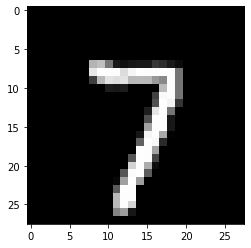

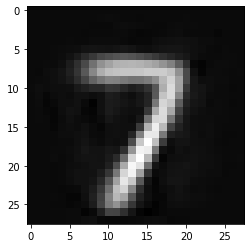

In [11]:
# Test result
import random

with torch.no_grad():
    model.eval()
    index = int(random.random() * test_x.size(0))

    recon = model(test_x[index].view(1, -1)).squeeze()
    show_image(test_x[index])
    show_image(recon)

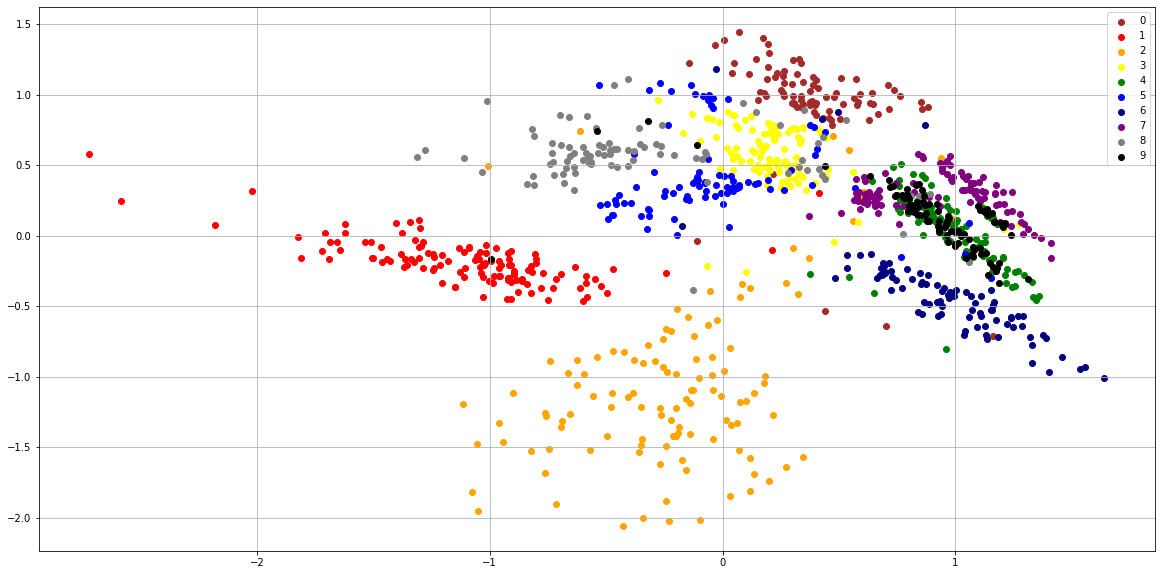

In [12]:
if config.bottleneck_size == 2:
    color_map = [
        'brown', 'red', 'orange', 'yellow', 'green',
        'blue', 'navy', 'purple', 'gray', 'black',
    ]
    
    plt.figure(figsize=(20, 10))
    with torch.no_grad():
        latents = model.encoder(test_x[:1000])
        
        for i in range(10):
            target_latents = latents[test_y[:1000] == i]
            target_y = test_y[:1000][test_y[:1000] == i]
            plt.scatter(target_latents[:, 0],
                        target_latents[:, 1],
                        marker='o',
                        color=color_map[i],
                        label=i)
        
        plt.legend()
        plt.grid(axis='both')
        plt.show()

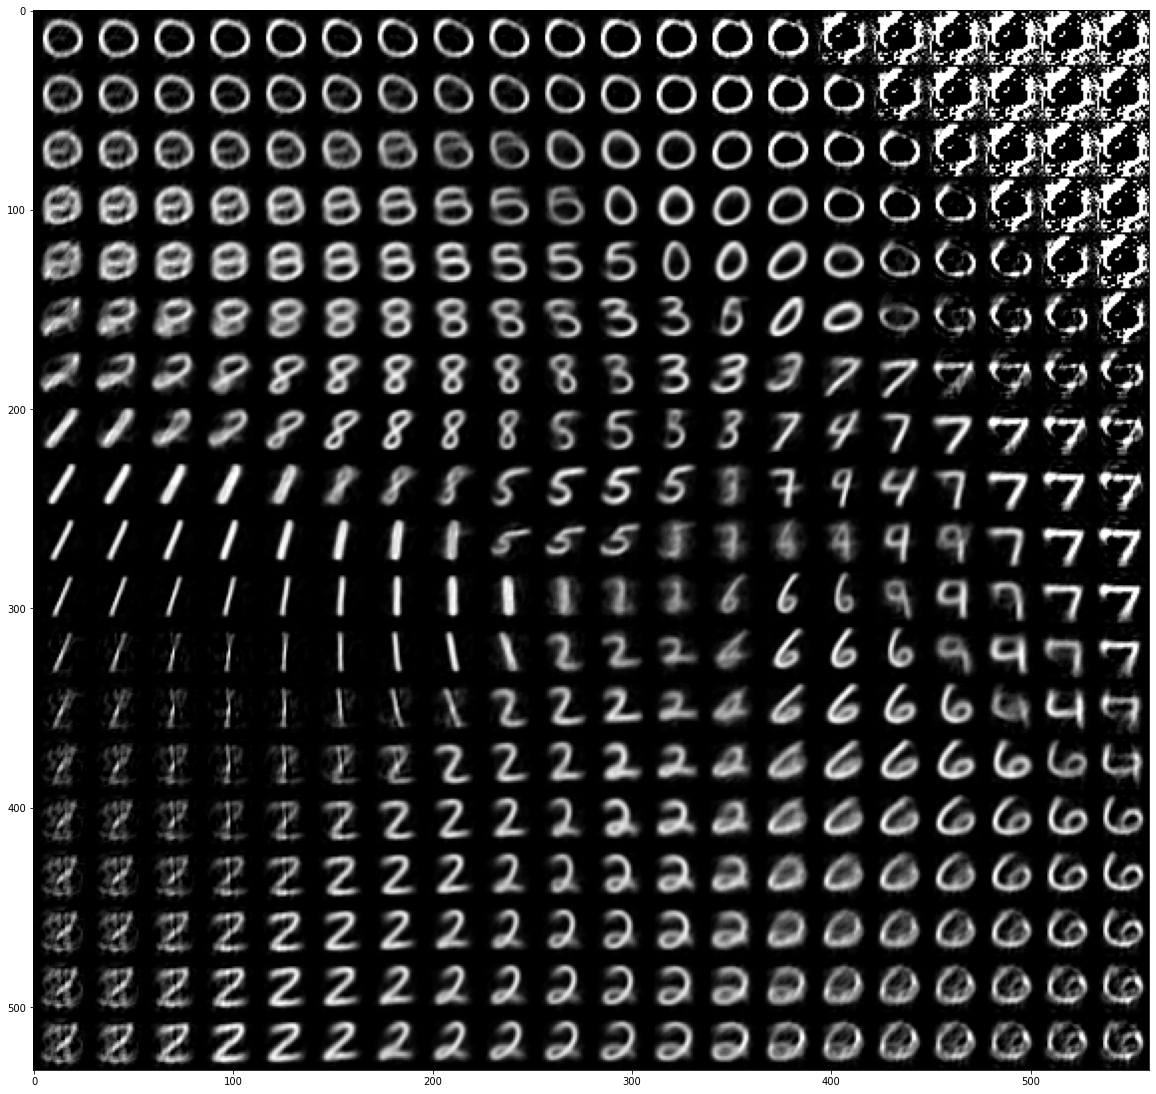

In [13]:
if config.bottleneck_size == 2:
    min_range, max_range = -2., 2.
    n = 20
    step = (max_range - min_range) / float(n)
    
    with torch.no_grad():
        lines = []

        for v1 in np.arange(min_range, max_range, step):
            z = torch.stack([
                torch.FloatTensor([v1] * n),
                torch.FloatTensor([v2 for v2 in np.arange(min_range,
                                                          max_range, step)]),
            ], dim=-1)
            
            line = torch.clamp(model.decoder(z).view(n, 28, 28), 0, 1)
            line = torch.cat([line[i] for i in range(n - 1, 0, -1)], dim=0)
            lines += [line]
            
        lines = torch.cat(lines, dim=-1)
        plt.figure(figsize=(20, 20))
        show_image(lines)